## Project: Transformer for Sentiment Analysis

(a) Data Pre-processing

  (1) Load data from Hugging Face Hub. Randomly select 10,000 data points for training
  and 1,000 data points for validation from the original ‘train’ dataset, and 2,000 test data points
  from the original ‘test’ dataset.
  
  (2) For convenience, now change the created train/val/test data from Hugging Face’s dataset to pandas dataframe. Pre-process the data by removing the punctuation marks and stop words,
  and converting all words to lowercase. Note that the regular expression operations (doc) and
  nltk library might be useful.

  (3) Convert the label into two types by the number of stars: P ositive ≥ 4, Negative ≤ 3.
  

Install all needed python libaries

In [2]:
!pip install datasets pandas nltk torch transformers

In [3]:
# Import all libaries
import pandas as pd
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
import re
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import AdamW

# Step 1

# Load the Yelp Review Full dataset from the Hugging Face Hub
dataset = load_dataset("yelp_review_full")
# Shuffle the train split of the dataset with a seed for reproducibility and select the first 10,000 entries for training
train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
# Shuffle the train split of the dataset with a different seed and select the first 1,000 entries for validation
valid_dataset = dataset["train"].shuffle(seed=43).select(range(1000))
# Shuffle the test split of the dataset with a seed and select the first 2,000 entries for testing
test_dataset = dataset["test"].shuffle(seed=44).select(range(2000))

# Step 2

# Download necessary resources from nltk, specifically stopwords for English
nltk.download('stopwords')
# Create a set of English stop words
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Convert all characters in the text to lowercase to normalize casing
    text = text.lower()
    # Remove all punctuation from the text using a regular expression
    text = re.sub(r'[^\w\s]', '', text)
    # Remove all stop words from the text
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Return the cleaned text
    return text

# Convert the training, validation datasets to Pandas DataFrames
train_df = train_dataset.to_pandas()
valid_df = valid_dataset.to_pandas()
test_df = test_dataset.to_pandas()

# Apply the preprocessing function to the 'text' column of the DataFrames
train_df['text'] = train_df['text'].apply(preprocess_text)
valid_df['text'] = valid_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Debug to print first few rows of the DataFrames to verify preprocessing
print(train_df.head())
print(valid_df.head())
print(test_df.head())

# Step 3

# Function to convert labels into two categories
def convert_label(label):
    # Return 'Positive' if label is 4 or 5, 'Negative' if it is 1, 2, or 3
    # Account for the fact that labels go from 0 to 4 instead of 1 to 5
    # so set positive to >= 3 rather than 4
    return 1 if label >= 3 else 0

# Apply the label conversion function to convert labels in the training DataFrame
train_df['label'] = train_df['label'].apply(convert_label)
# Apply the label conversion function to convert labels in the validation DataFrame
valid_df['label'] = valid_df['label'].apply(convert_label)
# Apply the label conversion function to convert labels in the test DataFrame
test_df['label'] = test_df['label'].apply(convert_label)

# Debug to print first few rows of the DataFrames to verify label conversion
print(train_df.head())
print(valid_df.head())
print(test_df.head())

/home/nikhil/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/nikhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   label                                               text
0      4  stalk truck ive industrial parks pretend tech ...
1      2  really knows good pho hung tha fuck desperate ...
2      4  love bloom salon stylist qualified provide exc...
3      0    excited eat difficult find closed 3 pm saturday
4      2  place food much cannot denied know small airpo...
   label                                               text
0      0  oh god really pittsburgh considers best sandwi...
1      2              beautiful hotel super cool water show
2      1  like bad nursing home food love kings fish hou...
3      4  great gyro great price doesnt look like much o...
4      0  seeing guy driving company vehicle throw cigar...
   label                                               text
0      2  went two girlfriends wed night seated immediat...
1      1  pizza nothing special canned mushrooms spinach...
2      2  pool140 cabana wasnt badservice horrible hones...
3      3  say impressed dennys systemati

(b) Input Data Preparation The input of the Transformer model should be a fixed-length
review sequence where integer numbers represent words. Here you need to build vocabulary for
the dataset and pad / truncate the review sequences to the same length.

Looking at length statistics for the dataset to figure what to truncate length to.

In [4]:
# Calculate the length of reviews
train_df['review_length'] = train_df['text'].apply(len)

# Display statistics about review lengths
print(train_df['review_length'].describe())

count    10000.000000
mean       455.837500
std        405.633721
min          0.000000
25%        178.750000
50%        338.000000
75%        602.000000
max       3433.000000
Name: review_length, dtype: float64


In [5]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# set max sequence length
max_length = 512

def prepare_data_loader(texts, labels, batch_size=32):
    # Tokenize texts
    tokenized_outputs = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    # Extract input_ids and attention_mask directly as tensors
    input_ids = tokenized_outputs['input_ids']
    attention_mask = tokenized_outputs['attention_mask']
    # Convert attention_mask to boolean where `True` corresponds to positions to ignore
    src_key_padding_mask = attention_mask == 0  # Invert mask: 0s in original mask should be `True` for ignoring
    # Ensure labels are a tensor
    labels = torch.tensor(labels, dtype=torch.long)
    # Create a TensorDataset from input_ids, attention_mask, and labels
    dataset = TensorDataset(input_ids, src_key_padding_mask, labels)
    # Create a DataLoader from the dataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Convert text and labels to lists before createing data loaders
train_text_lst = train_df['text'].tolist()
valid_text_lst = valid_df['text'].tolist()
test_text_lst = test_df['text'].tolist()

train_label_lst = train_df['label'].tolist()
valid_label_lst = valid_df['label'].tolist()
test_label_lst = test_df['label'].tolist()

# create data loaders
train_loader = prepare_data_loader(texts=train_text_lst,labels=train_label_lst)
valid_loader = prepare_data_loader(texts=valid_text_lst,labels=valid_label_lst)
test_loader = prepare_data_loader(texts=test_text_lst,labels=test_label_lst)



/home/nikhil/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# check to see the data structure of the data loader
for batch in train_loader:
    print(batch)
    print(type(batch))
    break

[tensor([[  101,  6659,  6659,  ...,     0,     0,     0],
        [  101,  2130,  8648,  ...,     0,     0,     0],
        [  101,  3314,  2173,  ...,     0,     0,     0],
        ...,
        [  101,  3712,  6496,  ...,     0,     0,     0],
        [  101,  2092,  2672,  ...,     0,     0,     0],
        [  101,  2307, 10733,  ...,     0,     0,     0]]), tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]]), tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1])]
<class 'list'>


(c) Transformer Implementation Implement a Transformer model which is composed of an encoder network (i.e., multi-head self-attention layers) and a prediction head mapping the hidden representation of input sequence into the label space (i.e., three classes). Find more details about Transformer in paper. You may need to implement positional embeddings, a vocabulary embedding table, and mask indicators for padded tokens. PyTorch is recommended for model implementation.

(d) Model Training and Finetuning

(1) Train the model with SGD (or Adam/AdamW) optimizer using mini-batch fashion
based on the training dataset.

(2) Plot two curves across training process, where the x-axis is the training epochs, and the y-axis is the training loss or validation accuracy.

(3) Finetune the transformer model, and save the best model with the highest validation
accuracy.

In [7]:
# Transformer model class
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, num_encoder_layers, dropout=0.1):
        super(TransformerModel, self).__init__()  # Call the constructor of the parent class

        self.embed_dim = embed_dim
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Creating an embedding layer
        # Positional encoding layer
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)  # Creating a positional encoding layer
        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        # Fully connected output layer
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, src, src_key_padding_mask):
        # Embedding layer
        src = self.embedding(src) * math.sqrt(self.embed_dim)
        # Positional encoding layer
        src = self.pos_encoder(src)
        if src_key_padding_mask is not None and src_key_padding_mask.dim() == 2:
            # Transpose if necessary to match (batch_size, src_seq_len)
            src_key_padding_mask = src_key_padding_mask.transpose(0, 1)  
        # Transformer encoder layer
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        # Global average pooling
        output = output.mean(dim=1)
        # Fully connected output layer
        output = self.fc_out(output)  
        # Log softmax activation
        return F.log_softmax(output, dim=1)

# Define the positional encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()  # Call the constructor of the parent class
        self.dropout = nn.Dropout(p=dropout)  # Dropout layer

        # Positional encoding calculation
        position = torch.arange(max_len).unsqueeze(1)  # Generating positions
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))  # Divisor term
        pe = torch.zeros(max_len, 1, d_model)  # Initializing positional encoding matrix
        pe[:, 0, 0::2] = torch.sin(position * div_term)  # Computing sin values for even indices
        pe[:, 0, 1::2] = torch.cos(position * div_term)  # Computing cos values for odd indices
        self.register_buffer('pe', pe)  # Registering positional encoding as buffer

    def forward(self, x):
        # Add positional encoding to input
        x = x + self.pe[:x.size(0)]  # Adding positional encoding to input tensor
        return self.dropout(x)  # Applying dropout to the input with positional encoding


In [11]:
# Initialize the model with specified parameters
model = TransformerModel(vocab_size=tokenizer.vocab_size, embed_dim=512, num_heads=8, num_classes=2, num_encoder_layers=6)

# Initialize the optimizer with AdamW and set learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define a function to calculate accuracy
def accuracy(predictions, labels):
    # Get predicted labels
    _, preds = torch.max(predictions, dim=1)
    # Calculate accuracy
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training function
def train(model, train_loader, valid_loader, optimizer, num_epochs=3):
    # Initialize list to store validation accuracy
    validation_accuracy = []
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        # Initialize total loss for epoch
        total_loss = 0
        # Iterate over batches in training data
        for batch in train_loader:
            # Unpack batch
            inputs, masks, labels = batch[0], batch[1], batch[2]
            #print(masks.dtype)  # Should output `torch.bool
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs, masks)
            # Calculate loss
            loss = F.nll_loss(outputs, labels)
            # Backpropagation
            loss.backward()
            # Optimizer step
            optimizer.step()
            # Accumulate total loss for epoch
            total_loss += loss.item()

        # Validation
        # Set model to evaluation mode
        model.eval()
        # Initialize total validation loss
        total_val_loss = 0
        # Initialize total accuracy
        total_accuracy = 0
        # Turn off gradients for validation
        with torch.no_grad():
            # Iterate over batches in validation data
            for batch in valid_loader:
                # Unpack batch
                inputs, masks, labels = batch[0], batch[1], batch[2]
                # Forward pass
                outputs = model(inputs, masks)
                # Calculate loss
                loss = F.nll_loss(outputs, labels)
                # Accumulate total validation loss
                total_val_loss += loss.item()
                # Accumulate total accuracy
                total_accuracy += accuracy(outputs, labels)
            # Calculate average accuracy
            avg_accuracy = total_accuracy / len(valid_loader)
            # Append average accuracy for epoch to list
            validation_accuracy.append(avg_accuracy)
    # Return list of validation accuracies
    return validation_accuracy

# Call the train function and store the validation accuracy
validation_acc = train(model, train_loader, valid_loader, optimizer, num_epochs=3)


/home/nikhil/miniconda3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


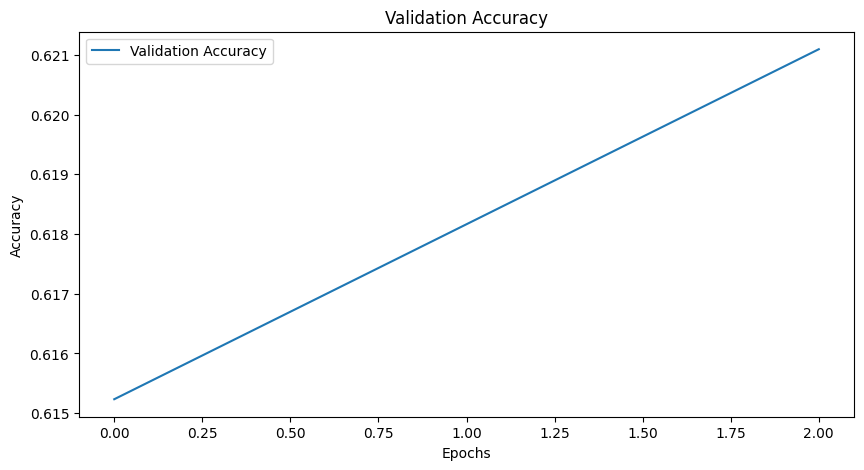

In [9]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(validation_acc, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(e) Test Result Analysis

  (1) Load the best model saved above and report the accuracy of the model on the test dataset.

  (2) What are the impacts of hyper-parameters, such as the hidden dimension and the number of attention layers, on the Transformer?


In [14]:
# Define a function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    # Predicted classes
    _, predicted = torch.max(y_pred, 1)
    # Count correct predictions
    correct = (predicted == y_true).float().sum()
    # Return accuracy
    return correct / y_true.shape[0]

# Define a function to evaluate the model on test data
def evaluate_model(model, test_loader):
    # Initialize total accuracy
    total_accuracy = 0
    # Initialize total samples
    total_samples = 0

    # Turn off gradients for evaluation
    with torch.no_grad():
        # Iterate over test data
        for inputs, masks, labels in test_loader:
            # Forward pass
            outputs = model(inputs, masks)
            # Calculate accuracy
            accuracy = calculate_accuracy(outputs, labels)
            # Accumulate accuracy
            total_accuracy += accuracy.item() * inputs.size(0)
            # Accumulate total samples
            total_samples += inputs.size(0)

    # Return average accuracy
    return total_accuracy / total_samples

# Set the model to evaluation mode
model.eval()
# Evaluate the model on test data and calculate accuracy
test_accuracy = evaluate_model(model, test_loader)
# Print the test accuracy
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.5985


The hidden dimension sets the size of how the data is represented inside the model. If I were to increase the hidden dimension or "embed_dim" it would be able to better understand the data but it would also increase the training time which is already 90 ish minutes. The attention layers or "num_heads" in my case controls the number of attention heads in each attention layer which means that in each of those layers the model can focus on different parts of the input sequence simultaneously or rather focus on different relationships at the same time. The other hyperparameters vocab_size, num_classes, num_encoder_layers, lr and epochs all impact the model in their own unqiue way. Vocab size tells the model how many unique tokens to expect from the input data, this helps the model size layers to handle the incoming number of tokens. Then in num classes we simply set the number of output options we have this helps the model define the output layer for the model. Next the encoder layers controls the number of encoding layers in the model as the name implies each of these encoding layers will contain the attention layers mentioned ealier as sub-layers. Lastly we have learning rate and epochs, learning rate controls how much the weights change through each update of the model, I could set it higher and the model will converge/train faster but it could also lead to overfitting the training set. The epochs control how many times the dataset is passed through the neural network during training, in the real world it would be set to something like 1000 but since I don't have a crazy amount of compute I'm setting it to 3 and even that is taking my pc about an hour and a half per run. The only reason I'm content with this model with these parameters is because I can't afford the training process to take longer and we can clearly see the validation accuracy increasing over each epoch so we know the model is improving and working as intended.